In [268]:
import numpy as np
import matplotlib.pyplot as plt

In [269]:
# 将当前变量空间中的数据映射到高维空间中，使用更高维度的超平面划分数据
# 相当于在高维空间解决线性问题，相当于在低维空间解决非线性问题

In [270]:
# 载入数据
def loadDataSet(fileName):
    dataMat =[]
    labelMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            lineArr = line.strip().split('\t')
            dataMat.append([float(lineArr[0]),float(lineArr[1])])
            labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [271]:
# 全局数据存贮对象
class optStruct:
    def __init__(self,dataMatIn,classLabels,C,toler,kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) # [1,Ek] 第一位是使能标志位，第二位是Ek值
        self.K = np.mat(np.zeros((self.m,self.m))) 
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X,self.X[i,:],kTup)

In [272]:
# 核函数
# 一列代表一个向量与输入矩阵內积计算值列表
def kernelTrans(X,A,kTup):
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == "lin":K =X *A.T
    elif kTup[0] == "rbf":
        for j in range(m):
            deltaRow =X[j,:] - A
            K[j] = deltaRow * deltaRow.T
        K = np.exp(K/(-2*kTup[1]**2))
    else: raise NameError('核函数出错')
    return K

In [273]:
# 计算误差值
def calcEk(oS,k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [274]:
# 从剩余alpha索引中随机选择一个
# i aplha下标
# m 所有alpha的数目
def selectJrand(i,m):
    j = i 
    while(j == i): # 保证从剩余中选取
        j = int(np.random.uniform(1,m))
    return j

In [275]:
# 启发式选取内层循环的j索引
def selectJ(i,oS,Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0] # 已计算过E值的j索引
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i :
                continue
            Ek = calcEk(oS,k) # 重新计算
            deltaE = abs(Ei-Ek) # 选取E最大值对应的j
            if deltaE > maxDeltaE:
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej
    else:
        j = selectJrand(i,oS.m) # 第一次寻找，随机寻找
        Ej = calcEk(oS,j)
    return j,Ej

In [276]:
#  调整大于H或小于L的aplha值
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    elif aj < L:
        aj = L
    return aj

In [277]:
# alpha值优化后需要存储Ek
def updateEk(oS,k):
    Ek = calcEk(oS,k)
    oS.eCache[k] = [1,Ek]

In [278]:
def innerL(i,oS):
    Ei = calcEk(oS,i)
    # 测试容错率
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] <oS.C)) or ((oS.labelMat[i]*Ei > oS.tol)and(oS.alphas[i] >0)):
        j,Ej = selectJ(i,oS,Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0,oS.alphas[j] - oS.alphas[i])
            H = min(oS.C,oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0,oS.alphas[j] + oS.alphas[i] -oS.C)
            H = min(oS.C,oS.alphas[j] + oS.alphas[i])
        if L==H:print("L==H");return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] # 核函数
        if eta >=0: print('eta >= 0 ');return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print('j not moving enough')
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        updateEk(oS,i)
        b1 = oS.b - Ei - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i]  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i]  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        if  (0<oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0<oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1+b2)/2.0
        return 1
    else:
        return 0

In [279]:
def smoP(dataMatIn,classLabels,C,toler,maxIter,kTup):
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler,kTup)
    iterNum = 0
    entireSet = True
    alphaPairsChanged = 0
    while(iterNum<maxIter) and ((alphaPairsChanged >0)or entireSet):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print('fullset, iterNUm: %d i: %d, pairs changed %d'%(iterNum,i,alphaPairsChanged))
            iterNum += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A >0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iterNum:%d i:%d, pairs changed %d"%(iterNum,i,alphaPairsChanged))
            iterNum += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
        print('iteration number: %d'%iterNum)
    return oS.b,oS.alphas

In [280]:
# plot with matplotlib
def plotBestFit(alphas,b,dataArr,labelArr):
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m,n= np.shape(dataArr)
    # 绘制两类数据点
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(m):
        if int(labelMat[i,0]) == 1.0:
            xcord1.append(dataMat[i,0])
            ycord1.append(dataMat[i,1])
        else:
            xcord2.append(dataMat[i,0])
            ycord2.append(dataMat[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s= 30,c = 'red',marker = 's')
    ax.scatter(xcord2,ycord2,s= 30,c = 'blue')
    # 绘制支持向量
    spVector = np.array([[dataMat[i,0],dataMat[i,1]] for i in range(m) if alphas[i] > 0.0])
#     print(spVector)
    ax.scatter(spVector[:,0],spVector[:,1],s= 100,color='', marker='o', edgecolors='black')
    plt.xlabel("X1")
    plt.ylabel('X2')
    plt.show()

In [281]:
def testRBF(k1 = 1.3):
    dataArr,labelArr = loadDataSet('./testSetRBF.txt')
    b,alphas = smoP(dataArr,labelArr,200,0.0001,10000,('rbf',k1))
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A>0)[0]
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    print('支持向量数: %d'%np.shape(sVs)[0])
    m,n = np.shape(dataMat)
    errorCount = 0
#     weights = dataMat.T*np.multiply(alphas,labelMat)
#     dataMat[0]*weights+b
    for i in range(m):
        kernelEval = kernelTrans(sVs,dataMat[i,:],('rbf',k1)) # 挑出alphas非零的数据，因为其他数据即使做了核变换最后也会变成0
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr[i]):errorCount += 1
    print('训练集错误率为:%f'%(errorCount/m))
    plotBestFit(alphas,b,dataArr,labelArr)
    
    dataArr2,labelArr2 = loadDataSet('./testSetRBF2.txt')
    dataMat2 = np.mat(dataArr2)
    labelMat2 = np.mat(labelArr2).transpose()
    m2,n2 = np.shape(dataMat2)
    errorCount2 = 0
    for i in range(m2):
        kernelEval = kernelTrans(sVs,dataMat2[i,:],('rbf',k1)) # 挑出alphas非零的数据，因为其他数据即使做了核变换最后也会变成0,s所以只需要和支持向量乘就可以了
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr2[i]):errorCount2 += 1
    print('测试集错误率为:%f'%(errorCount2/m2))

fullset, iterNUm: 0 i: 0, pairs changed 1
fullset, iterNUm: 0 i: 1, pairs changed 2
fullset, iterNUm: 0 i: 2, pairs changed 3
fullset, iterNUm: 0 i: 3, pairs changed 4
fullset, iterNUm: 0 i: 4, pairs changed 4
fullset, iterNUm: 0 i: 5, pairs changed 5
fullset, iterNUm: 0 i: 6, pairs changed 6
fullset, iterNUm: 0 i: 7, pairs changed 6
fullset, iterNUm: 0 i: 8, pairs changed 6
fullset, iterNUm: 0 i: 9, pairs changed 6
fullset, iterNUm: 0 i: 10, pairs changed 7
fullset, iterNUm: 0 i: 11, pairs changed 7
fullset, iterNUm: 0 i: 12, pairs changed 7
fullset, iterNUm: 0 i: 13, pairs changed 8
fullset, iterNUm: 0 i: 14, pairs changed 9
fullset, iterNUm: 0 i: 15, pairs changed 10
fullset, iterNUm: 0 i: 16, pairs changed 11
fullset, iterNUm: 0 i: 17, pairs changed 11
fullset, iterNUm: 0 i: 18, pairs changed 12
fullset, iterNUm: 0 i: 19, pairs changed 13
fullset, iterNUm: 0 i: 20, pairs changed 13
fullset, iterNUm: 0 i: 21, pairs changed 14
fullset, iterNUm: 0 i: 22, pairs changed 14
fullset, iter

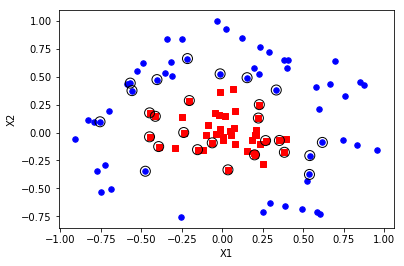

错误率为:0.020000


In [288]:
testRBF(1.0)

L==H
fullset, iterNUm: 0 i: 0, pairs changed 0
fullset, iterNUm: 0 i: 1, pairs changed 1
fullset, iterNUm: 0 i: 2, pairs changed 2
fullset, iterNUm: 0 i: 3, pairs changed 3
fullset, iterNUm: 0 i: 4, pairs changed 3
fullset, iterNUm: 0 i: 5, pairs changed 4
fullset, iterNUm: 0 i: 6, pairs changed 4
fullset, iterNUm: 0 i: 7, pairs changed 5
fullset, iterNUm: 0 i: 8, pairs changed 5
fullset, iterNUm: 0 i: 9, pairs changed 5
fullset, iterNUm: 0 i: 10, pairs changed 6
fullset, iterNUm: 0 i: 11, pairs changed 7
fullset, iterNUm: 0 i: 12, pairs changed 8
fullset, iterNUm: 0 i: 13, pairs changed 9
fullset, iterNUm: 0 i: 14, pairs changed 10
fullset, iterNUm: 0 i: 15, pairs changed 11
fullset, iterNUm: 0 i: 16, pairs changed 12
fullset, iterNUm: 0 i: 17, pairs changed 13
fullset, iterNUm: 0 i: 18, pairs changed 14
fullset, iterNUm: 0 i: 19, pairs changed 15
fullset, iterNUm: 0 i: 20, pairs changed 15
fullset, iterNUm: 0 i: 21, pairs changed 16
fullset, iterNUm: 0 i: 22, pairs changed 16
fullset

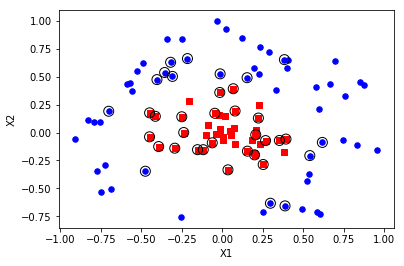

错误率为:0.060000


In [289]:
testRBF(1.3)